
Le mot décodé est :
https://www.google.com/search?q=uca&oq=uca+&gs_lcrp=EgZjaHJvbWUqBwgAEAAYjwIyBwgAEAAYjwIyDAgBECMYJxiABBiKBTIHCAIQLhiABDIMCAMQABgUGIcCGIAEMgcIBBAAGIAEMgYIBRBFGDwyBggGEEUYPDIGCAcQRRg80gEHMzc3ajBqN6gCALACAA&sourceid=chrome&ie=UTF-8                                                                                                                                                                           


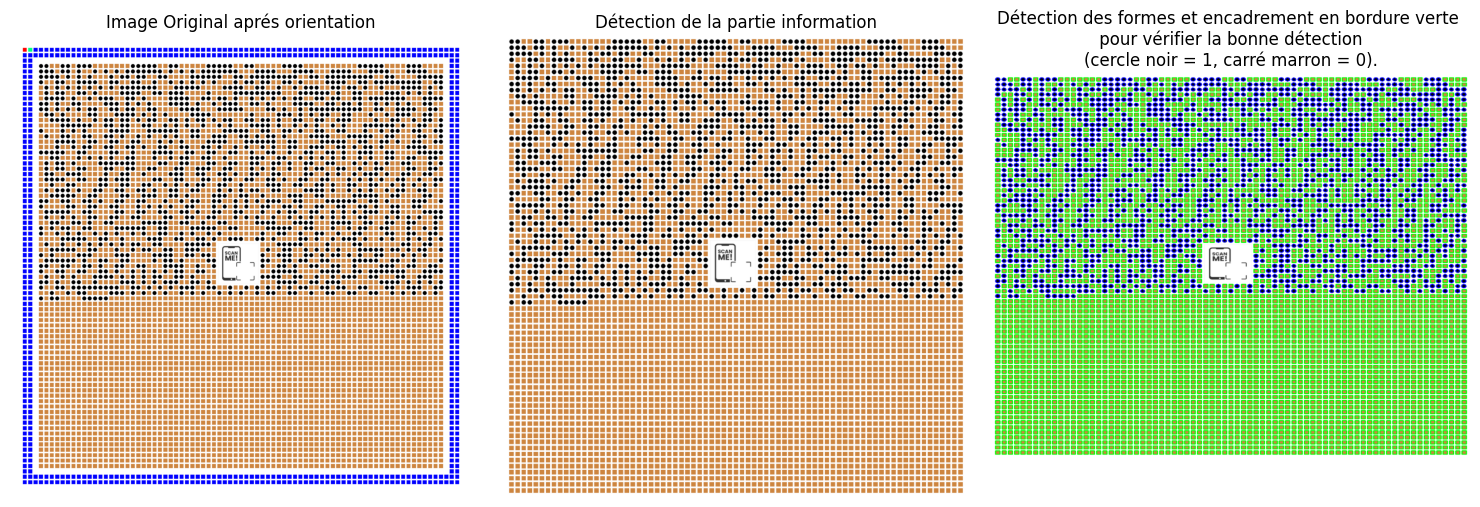

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialisation de la figure matplotlib pour afficher les résultats
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Crée une figure avec 3 sous-graphiques côte à côte

# Variable globale pour suivre l'index du sous-graphique courant
current_index = 0

def afficher_image(img, titre, axs, index):
    """Affiche une image dans un sous-graphique matplotlib avec un titre"""
    axs[index].imshow(img)
    axs[index].set_title(titre)
    axs[index].axis('off')

def is_square(approx):
    """Détermine si un contour approximé est un carré avec une certaine tolérance"""
    if len(approx) == 4:  # Un carré a 4 côtés
        pts = np.array(approx).reshape(-1, 2)
        # Calcule les distances entre les points consécutifs
        distances = [np.linalg.norm(pts[i] - pts[(i+1)%4]) for i in range(4)]
        max_diff = max(distances) - min(distances)
        # Vérifie si les côtés sont de longueur similaire (tolérance de 20%)
        if max_diff < max(distances) * 0.2:
            return True
    return False

def detect_useful_region_and_orientation(image_path):
    """Détecte la région utile de l'image et corrige son orientation"""
    # Chargement et conversion de l'image
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    display_image = image.copy()  # Copie pour l'affichage des détections
    
    # --- Détection des marqueurs verts (carrés) ---
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([85, 255, 255])
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    # Nettoyage du masque avec une opération morphologique
    kernel = np.ones((3,3), np.uint8)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel)
    contours_green, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    green_squares = []
    for contour in contours_green:
        area = cv2.contourArea(contour)
        if area < 100:  # Filtre les petits contours
            continue
            
        # Approximation du contour pour détecter les formes carrées
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if is_square(approx):
            # Stocke les coordonnées du centre du carré
            x, y, w, h = cv2.boundingRect(approx)
            center_x = x + w // 2
            center_y = y + h // 2
            green_squares.append((center_x, center_y))
            cv2.drawContours(display_image, [approx], -1, (0, 0, 255), 2)  # Dessine en rouge

    # --- Détection des marqueurs rouges (carrés) ---
    lower_red1 = np.array([0, 130, 130])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 150, 150])
    upper_red2 = np.array([180, 255, 255])
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask_red1, mask_red2)
    contours_red, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    red_squares = []
    for contour in contours_red:
        if cv2.contourArea(contour) < 50:  # Filtre plus strict pour les marqueurs rouges
            continue
            
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if is_square(approx):
            x, y, w, h = cv2.boundingRect(approx)
            center_x = x + w // 2
            center_y = y + h // 2
            red_squares.append((center_x, center_y))
            cv2.drawContours(display_image, [approx], -1, (0, 255, 0), 2)  # Dessine en vert

    # === Correction de l'orientation de l'image ===
    if len(red_squares) >= 1 and len(green_squares) >= 1:
        # On suppose qu'il n'y a qu'une paire de marqueurs
        red_center = red_squares[0]
        green_center = green_squares[0]
        
        # Si le marqueur rouge est à droite du vert, rotation de 180°
        if red_center[0] > green_center[0]:
            image = cv2.rotate(image, cv2.ROTATE_180)
            print("Image tournée de 180 degrés")

            # Mise à jour des coordonnées après rotation
            height, width = image.shape[:2]
            green_center = (width - green_center[0], height - green_center[1])
            red_center = (width - red_center[0], height - red_center[1])
        
        # Rotation fine pour aligner les marqueurs horizontalement
        image = rotate_image_based_on_markers(image, red_center, green_center)
        
        # Affichage de l'image orientée
        img1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        afficher_image(img1, "Image Original aprés orientation", axs, 0)
        
    else:
        print("Pas assez de marqueurs détectés pour l'orientation")
        return None

    # === Détection de la région utile (zone bleue) ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Recherche itérative de la région utile en partant des bords
    height, width = image.shape[:2]
    x_start, y_start = 0, 0
    x_end, y_end = width, height
    threshold = 10  # Pas de rétrécissement
    
    while True:
        mask = np.zeros_like(mask_blue)
        cv2.rectangle(mask, (x_start, y_start), (x_end, y_end), 255, -1)
        if cv2.countNonZero(cv2.bitwise_and(mask, mask_blue)) > 0:
            # Réduit la zone jusqu'à ne plus trouver de bleu
            x_start += threshold
            y_start += threshold
            x_end -= threshold
            y_end -= threshold
        else:
            break
        if x_end <= x_start or y_end <= y_start:
            break
    
    # Extraction de la région d'intérêt finale
    roi = image[y_start:y_end, x_start:x_end]
    
    # Affichage de la ROI détectée
    resized_roi = cv2.resize(roi, (800, 800))
    img1 = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2RGB)
    afficher_image(img1, "Détection de la partie information", axs, 1)
    
    return roi

def rotate_image_based_on_markers(image, red_center, green_center):
    """Effectue une rotation précise de l'image pour aligner les marqueurs"""
    
    # Calcul de l'angle entre les marqueurs
    dx = green_center[0] - red_center[0]
    dy = green_center[1] - red_center[1]
    angle = np.degrees(np.arctan2(dy, dx))
    
    # Détermination de la rotation nécessaire en fonction de l'angle
    if angle > -45 and angle <= 45:
        if green_center[0] > red_center[0]:
            # Orientation correcte - pas de rotation
            return image
        else:
            # Rotation de 180 degrés
            return cv2.rotate(image, cv2.ROTATE_180)
    elif angle > 45 and angle <= 135:
        # Rotation de 90 degrés antihoraire
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif angle > -135 and angle <= -45:
        # Rotation de 90 degrés horaire
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    else:
        # Rotation de 180 degrés
        return cv2.rotate(image, cv2.ROTATE_180)

def interpret_and_create_matrix(roi):
    """Interprète la ROI pour créer une matrice binaire"""
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # --- Détection des carrés marron (représentant des 0) ---
    lower_brown = np.array([0, 30, 30])
    upper_brown = np.array([25, 255, 255])
    brown_mask = cv2.inRange(hsv, lower_brown, upper_brown)

    # --- Détection des cercles noirs (représentant des 1) ---
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, black_mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

    # --- Extraction des contours ---
    contours_brown, _ = cv2.findContours(brown_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_black, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    elements = []

    # --- Traitement des carrés marron ---
    for contour in contours_brown:
        if cv2.contourArea(contour) < 50:
            continue
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if is_square(approx):
            x, y, w, h = cv2.boundingRect(approx)
            center_x = x + w // 2
            center_y = y + h // 2
            elements.append(("0", center_x, center_y))
            cv2.drawContours(roi, [approx], -1, (0, 255, 0), 2)  # Dessine en vert

    # --- Traitement des cercles noirs ---
    for contour in contours_black:
        if cv2.contourArea(contour) < 50:
            continue
        (x, y), radius = cv2.minEnclosingCircle(contour)
        area = cv2.contourArea(contour)
        circle_area = np.pi * (radius ** 2)
        # Vérifie la circularité
        if radius > 5 and 0.7 < (area / circle_area) < 1.3:
            elements.append(("1", int(x), int(y)))
            cv2.circle(roi, (int(x), int(y)), int(radius), (255, 0, 0), 2)  # Dessine en bleu

    def group_by_lines(elements, tolerance=15):
        """Regroupe les éléments par ligne en fonction de leur coordonnée y"""
        lines = []
        for el in sorted(elements, key=lambda e: e[2]):  # Tri par y
            for line in lines:
                if abs(line[0][2] - el[2]) <= tolerance:
                    line.append(el)
                    break
            else:
                lines.append([el])  # Nouvelle ligne
        for line in lines:
            line.sort(key=lambda e: e[1])  # Tri par x dans chaque ligne
        return [el for line in lines for el in line]  # Aplatit la liste

    # --- Organisation des éléments dans la matrice ---
    elements = group_by_lines(elements)

    # --- Création de la matrice 7x7 ---
    total = len(elements)
    rows, cols = total // 7 + (1 if total % 7 else 0), 7
    matrix = [['' for _ in range(cols)] for _ in range(rows)]

    for i in range(rows * cols):
        row = i // cols
        col = i % cols
        if i < len(elements):
            matrix[row][col] = elements[i][0]
        else:
            matrix[row][col] = '0'  # Remplissage avec des 0 si nécessaire
            
    # Assurance que toutes les cases sont remplies
    for row in matrix:
        for i in range(len(row)):
            if row[i] == '':
                row[i] = '0'

    # Affichage des détections finales
    roi = cv2.resize(roi, (1000, 800))
    img1 = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    afficher_image(img1, "Détection des formes et encadrement en bordure verte \n pour vérifier la bonne détection \n(cercle noir = 1, carré marron = 0).", axs, 2)
    return matrix

def decode_hamming_message(encoded_bits):
    """Décode un message encodé avec le code de Hamming (7,4)"""
    decoded_msg = ""
    for i in range(0, len(encoded_bits), 14):
        # Décodage par blocs de 14 bits (2x7 bits)
        char_bits = encoded_bits[i:i+14]
        
        # Complétion avec des 0 si nécessaire
        if len(char_bits) < 14:
            char_bits += [0] * (14 - len(char_bits))
        
        # Décodage Hamming pour chaque partie de 7 bits
        high_data = hamming74_decode(char_bits[:7])
        low_data = hamming74_decode(char_bits[7:])
        
        # Reconstruction du caractère ASCII
        ascii_val = (int("".join(map(str, high_data)), 2) << 4) + int("".join(map(str, low_data)), 2)
        decoded_msg += chr(ascii_val)
    return decoded_msg

def hamming74_decode(bits):
    """Décode 7 bits encodés avec Hamming(7,4) et corrige les erreurs simples"""
    p1, p2, d0, p3, d1, d2, d3 = bits
    # Calcul des bits de syndrome
    s1 = p1 ^ d0 ^ d1 ^ d3
    s2 = p2 ^ d0 ^ d2 ^ d3
    s3 = p3 ^ d1 ^ d2 ^ d3
    error_pos = s1 + (s2 << 1) + (s3 << 2)
    if error_pos != 0:  # Correction d'erreur si nécessaire
        bits[error_pos - 1] ^= 1
    return bits[2], bits[4], bits[5], bits[6]  # Retourne les 4 bits de données

# Exemple d'utilisation
roi = detect_useful_region_and_orientation("Qr_code.png")
matrix = interpret_and_create_matrix(roi)
# Conversion de la matrice en liste plate de bits
flat_bits = [int(elem) for row in matrix for elem in row if elem != '']
# Décodage du message
mot=decode_hamming_message(flat_bits)
print("\nLe mot décodé est :")
print(mot)
# Affichage des graphiques
plt.tight_layout()
plt.show()